In [9]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#K-means clustering algo
from sklearn.cluster import KMeans
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt
import shutil

In [51]:
#Base Folder Paths
base_folder = 'converted'
test_folder = 'test2'
base_path = os.path.join(base_folder, test_folder)
#Normal Sample and cluster paths
sample_dir_name = 'samp'
sample_path = os.path.join(base_path, sample_dir_name)
#If sample folder exist
if os.path.isdir(sample_path):
    cluster_dir_name = sample_dir_name+'_cluster'
    cluster_path = os.path.join(base_path, cluster_dir_name)
    os.makedirs(cluster_path, exist_ok=True)
    #Attack Sample and Cluster paths
    # sample_path = os.path.join(base_path,'attack_samples','1')
    # cluster_path = os.path.join(base_path,'attack_ip_cluster','1')
    os.makedirs(cluster_path, exist_ok=True)
    #File to store centroids
    centroid_filename = 'centroids.csv'
    #File to store feature list
    features_filename = 'features.csv'
#Defining features
features = [6,17] #(TCP:6, UDP:17)    

In [52]:
import glob
#Merge sample files to create bigger sameple
def merge_sample_files(sample_path, merge_count):
    #Make copy
    head, tail = os.path.split(sample_path)
    copy_path = os.path.join(head,tail+'_copy')
    if os.path.isdir(copy_path):
        shutil.rmtree(copy_path)
    shutil.copytree(sample_path, copy_path)
    #delete all the file and recreate folder
    shutil.rmtree(sample_path)
    os.makedirs(sample_path, exist_ok=True)
    file_number = 1
    count = 0
    filenames = sorted(glob.glob(os.path.join(copy_path,'*')),  key=os.path.getmtime)
    for filename in filenames:
        if count == 0:
            df = pd.read_csv(filename, index_col=0)
            count += 1
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df)
            count += 1
        if count == merge_count:
            df.to_csv(os.path.join(sample_path,str(file_number)))
            df = df.drop(df.index, inplace=True)
            count = 0
            file_number +=1

In [53]:
# merge_count = 3
# merge_sample_files(sample_path, merge_count)

In [ ]:
sample_file

In [70]:
def get_feature_dataframe(sample_file, features):
        df = pd.read_csv(sample_file, index_col=0)
        #Filter Columns
        df = df[['ip.dst', 'ip.proto', 'sniff_timestamp', 'sample']]
        #Remove null destinations
        df = df[df['ip.dst'].notnull()]
        #Rename Columns
        df.columns = ['ip', 'protocol', 'time_stamp', 'sample']
        #Get count for each ip
        df = df.groupby(['ip', 'protocol']).size().unstack().fillna(0).astype(int)
        #Select TCP and UDP as only fetures (TCP:6, UDP:17)
        df = df[features]
        if(set(df.columns) != set(features)):
            print(df.columns, features)
            non_columns = set(features) - set(df.columns)
            for c in non_columns:
                df.insert(loc=features.index(c), column=c, value=0)
        return df, sample_file

In [71]:
filenames = sorted(glob.glob(os.path.join(sample_path,'*')),  key=os.path.getmtime)
df, sample_file = get_feature_dataframe(filenames[0], features)

In [72]:
sample_file

'converted/test2/samp/1'

In [86]:
#Create feature dataframes from the sample files
def get_feature_vector_list(sample_path, features):
    sample_df_list = []
    sample_file_list = []
    for filename in os.listdir(sample_path):
        sample_file = os.path.join(sample_path,filename)
        df, sample_file = get_feature_dataframe(sample_file, features)
        sample_df_list.append(df)
        sample_file_list.append(sample_file)
    return sample_df_list, sample_file_list   

In [87]:
from sklearn.cluster import KMeans
#Find optimal number of clusters for k-means clustering using elbow method.
def elbow_method(X_trans):
    elbow_count = 0
    range_val = 10
    nc = range(1, range_val)
    kmeans = [KMeans(n_clusters=i) for i in nc]
    score = [kmeans[i].fit(X_trans).score(X_trans) for i in range(len(kmeans))]
    total_diff = abs(score[0] - score[len(score) -1])
    for i in range(range_val - 2):
        percent_diff = abs(score[i] - score[i+1])/total_diff
        if percent_diff < 0.01:
            opt_clust_count = i
            break
#     plt.plot(nc,score)
#     plt.xlabel('Number of Clusters')
#     plt.ylabel('Score')
#     plt.title('Elbow Curve')
#     plt.show()
    return opt_clust_count

In [88]:
df_list, sample_file_list = get_feature_vector_list(sample_path, features)

In [90]:
#Apply elbow method on all the samples and get their mean
def get_optimal_cluster_count(df_list):
    elbow_vals = []
    for df in df_list:
        X = df.values
        #Create scaling
        scaler = preprocessing.StandardScaler().fit(X)
        #Transform Traning data
        X_trans = scaler.transform(X)
        elbow = elbow_method(X_trans)
        elbow_vals.append(elbow)
    return int(np.floor(np.mean(elbow_vals)))

In [91]:
cluster_count = get_optimal_cluster_count(df_list)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [92]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
def PCA_component_analysis(X_std):
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    # Create a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

    # # Sort from high to low
    eig_pairs.sort(key = lambda x: x[0], reverse= True)

    # Calculation of Explained Variance from the eigenvalues
    tot = sum(eig_vals)
    var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
    cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

    # PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
    plt.figure(figsize=(10, 5))
    plt.bar(range(9), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
    plt.step(range(9), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.show()

In [93]:
def get_kmeans_centroid(feature_df, cluster_count):
    """ 
    X: feature vector 
    cluster_count: Number of clusters to be used for k-means
    """
    df_centroid = {}
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #Data Fitting using K-means
    kmeans = KMeans(n_clusters=cluster_count)
    kmeans.fit(X_trans)
    #Insert cluster center to its corrosposnding dataframe each dataframe.
    #Dataframe 0 contain all the clusters centers associated with 0th cluster
    first = True
    for i in range(kmeans.cluster_centers_.shape[0]):
        s = pd.Series(kmeans.cluster_centers_[i], index=feature_df.columns)
        if(first):
            df_centroid = pd.DataFrame(columns=feature_df.columns)
            first = False
        df_centroid = df_centroid.append(s,ignore_index=True)
    return df_centroid

In [94]:
#Find the median of all the centroid which will be better estimate of the centroid for all future k-means clustering
def kmeans_centroids_median(sample_frames, features, cluster_count, centroid_filename, features_filename):
    """
    sample_frames: list of feature vector datafames
    centroid_filename: File in which centroid has to be stored for future analyasis
    features_filename: File in which feature list will be stored
    """
    df_concat = pd.DataFrame(columns=features)
    for df in sample_frames:
        #Run kmeans and get centroid
        df_centroid = get_kmeans_centroid(df, cluster_count)
        #Create list of centroids
        df_concat = df_concat.append(df_centroid)
    centroids = []
    #Find median for each centroid and store them in file
    for c in range(cluster_count):
        med = np.median(df_concat.loc[c], axis=0) # e.g. df_concat.loc[0] is df of clister 0
        centroids.append(med)
    #Save centroids and features in files for future use
    np.savetxt(os.path.join(base_path, centroid_filename), np.asarray(centroids), delimiter=",")
    np.savetxt(os.path.join(base_path, features_filename), np.asarray(list(features)), delimiter=",")

In [95]:
cluster_count

3

In [96]:
kmeans_centroids_median(df_list, features, cluster_count, centroid_filename, features_filename)

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [97]:
#Get centroids and feature from the files
def read_centroid_features(centroid_filename, features_filename):
    centroids = np.genfromtxt(os.path.join(base_path,centroid_filename), delimiter=',')
    features = np.genfromtxt(os.path.join(base_path,features_filename), delimiter=',')
    return centroids, features

In [108]:
from sklearn.decomposition import PCA
def draw_clusters(X, centroids, kmeans):
    #Use PCA component analysis for visuals
    if X.shape[1] > 2:
        reduced_X = PCA(n_components=2).fit_transform(X)
    else:
        reduced_X = X
   
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_X[:, 0].min() - 1, reduced_X[:, 0].max() + 1
    y_min, y_max = reduced_X[:, 1].min() - 1, reduced_X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')   
    #Plot the data points (PCA reduced components)
    plt.plot(reduced_X[:,0],reduced_X[:,1],  'k.', markersize=3) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.title('K-means clustering with (PCA-reduced data), Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [99]:
from scipy.spatial.distance import euclidean
#Calculate distance of feature vector point from the its cluster center
def k_mean_dist(feature_vector, label, cluster_centers):
    distances = []
    for i, d in enumerate(feature_vector):
        center = cluster_centers[label[i]]
        distance = euclidean(d,center)
        #distance = np.linalg.norm(d - center)
        distances.append(distance)
    return distances

In [112]:
centroids, features = read_centroid_features(centroid_filename, features_filename)
def kmeans_clustering(feature_df, centroids):
    X = feature_df.values
    #Create scaling
    scaler = preprocessing.StandardScaler().fit(X)
    #Transform Traning data
    X_trans = scaler.transform(X)
    #k means clustering using provided centroids 
    kmeans = KMeans(n_clusters=centroids.shape[0], init=centroids)
    clusters = kmeans.fit_predict(X_trans)
    #Plot clusters and data using PCA component analysis
    draw_clusters(X_trans, centroids, kmeans)
    #Find distance of each point from the centroid
    distances = k_mean_dist(X_trans, clusters, centroids)
    #Getting the labels/clusters and distances of each IP from centroid
    cluster_df = pd.DataFrame({'cluster': kmeans.labels_})
    distance_df = pd.DataFrame({'distance': distances})
    #Attaching label and distance to existing df and write new dataframe to file
    df = pd.concat([feature_df.reset_index(), cluster_df, distance_df], axis=1).set_index('ip')
    return df

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


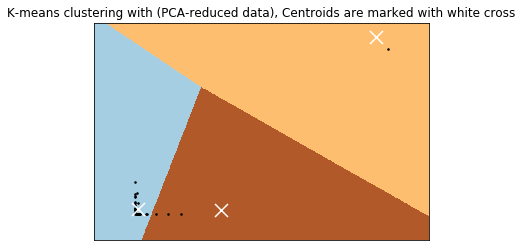

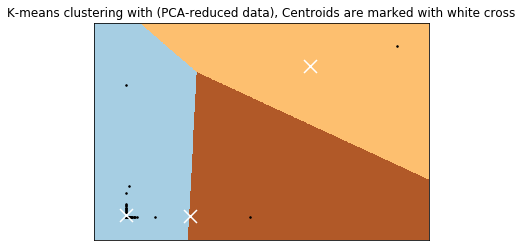

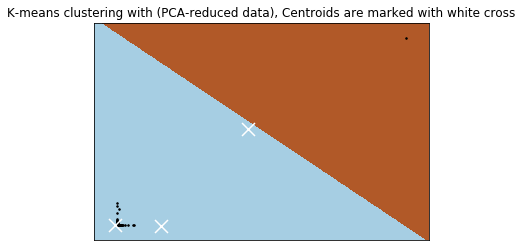

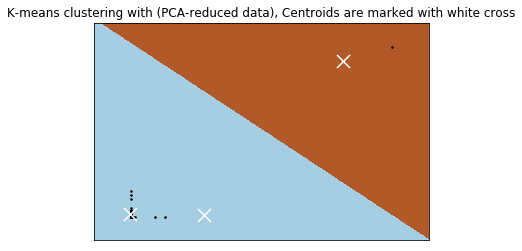

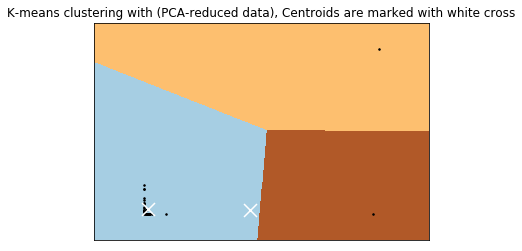

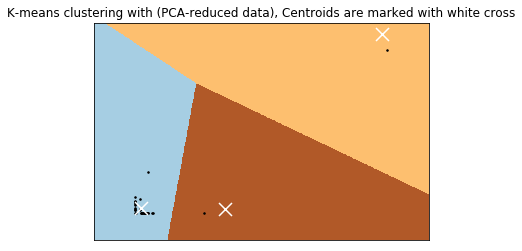

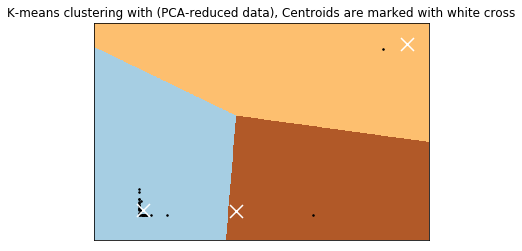

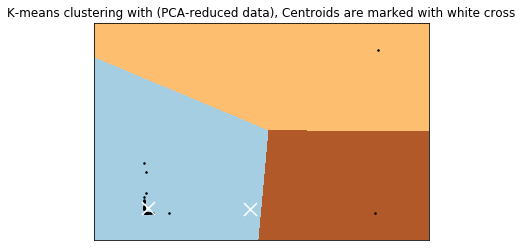

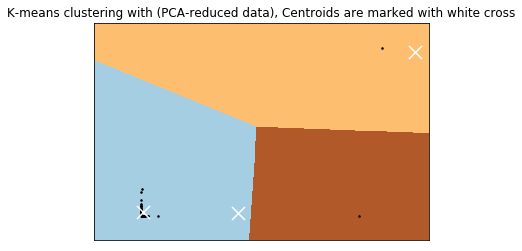

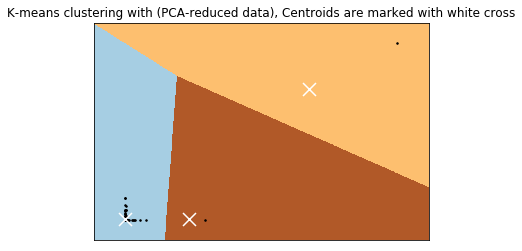

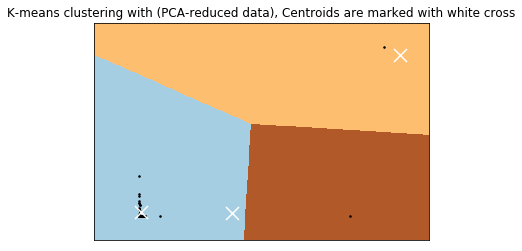

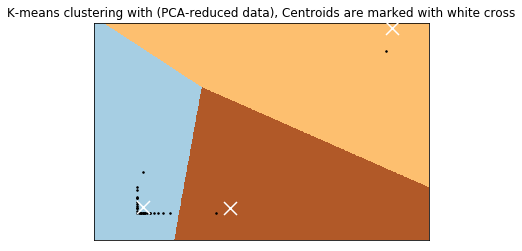

In [113]:
#Cluster all the samples and store them
for i, feature_df in enumerate(df_list):
    clustered_df = kmeans_clustering(feature_df, centroids)
    head, filename = os.path.split(sample_file_list[i])
    clustered_df.to_csv(os.path.join(cluster_path,str(filename)))

In [ ]:
#For a given IP address find how many time a given cluster it was assigned to.
from itertools import groupby
def get_IP_cluster_count_dict(cluster_path):    
    ip_dict = dict()
    filenames = glob.glob(os.path.join(cluster_path,'*'))
    for filename in filenames:
        with open(filename, newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                if row['ip'] in ip_dict:
                    #print(row['ip'],ip_dict[row['ip']])
                    ip_dict[row['ip']] = ip_dict[row['ip']] + [row['cluster']]
                else:
                    ip_dict[row['ip']] = [row['cluster']]
    #Find how many time IP was assigned to a given cluster
    ip_cluster_dict = dict()
    for key, value in ip_dict.items():
        ip_cluster_dict[key] = {k: len(list(group)) for k, group in groupby(value)}
    return ip_cluster_dict

In [ ]:
ip_cluster_dict = get_IP_cluster_count_dict(cluster_path)

In [ ]:
#ip_cluster_dict

In [ ]:
def get_cluster_feature_vector_dict(cluster_path):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['cluster','ip'])
    clusters = df.index.get_level_values(0).unique()
    for c in clusters:
        cluster_dict[c] = df.loc[c].iloc[:,:-1].values
    return cluster_dict

In [ ]:
def plot_outlier_detecton(X_train, clf):
    
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    
    # plot the levels lines and the points
    print(clf.name)
    if clf.name == "lof":
        # decision_function is private for LOF
        Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    print(Z.max(), Z.min())
    plt.title("Novelty Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    #plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    
    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")
    plt.show()

In [ ]:
#SKlearn SVM
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
def one_class_svm_for_clusters(cluster_feature_dict):
    svm_dict = dict()
    scalar_dict = dict()
    for key, value in cluster_feature_dict.items():
        X_train = value
        #Get scaler
        scaler = preprocessing.StandardScaler().fit(X_train)
        scalar_dict[key] = scaler 
        #Transform Traning data
        X_trans = scaler.transform(X_train)
        # fit the model
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
        clf.fit(X_trans)
        clf.name = 'svm'
        plot_outlier_detecton(X_trans, clf)
        
        clf = LocalOutlierFactor(contamination=0.01)
        clf.fit(X_trans)
        clf.name= 'lof'
        plot_outlier_detecton(X_trans, clf)
        #Store trained SVM for each IP
        svm_dict[key] = clf
    return svm_dict, scalar_dict

In [ ]:
#merge_sample_files(sample_path,3)
d = get_cluster_feature_vector_dict(cluster_path)

In [ ]:
#svm_dict, scaler_dict = one_class_svm_for_clusters(d)

In [ ]:
svm_dict

In [ ]:
#Predict for the give destination if it is normal or not
X_test = [[0,120]]
X_test_tran = scaler_dict[0].transform(X_test)
svm_dict[0].predict(X_test_tran)